#### **Context**

The <a href="https://www.kaggle.com/datasets/jillanisofttech/market-segmentation-in-insurance-unsupervised">sample Dataset</a> summarizes the usage behavior of about 9000 active credit cardholders during the last 6 months. The file is at a customer level with 18 behavioral variables.

##### **Credit Card Dataset Column Meanings**

| Column Name | Meaning in Credit Card Context |
|-------------|-------------------------------|
| CUST_ID | Unique identifier for each customer |
| BALANCE | Average balance amount maintained on the credit card |
| BALANCE_FREQUENCY | How frequently the customer maintains a balance (0-1 scale) |
| PURCHASES | Total amount of purchases made using the credit card |
| ONEOFF_PURCHASES | Total amount spent on one-time/single purchases |
| INSTALLMENTS_PURCHASES | Total amount spent on installment purchases |
| CASH_ADVANCE | Total amount taken as cash advances from the credit card |
| PURCHASES_FREQUENCY | How frequently the customer makes purchases (0-1 scale) |
| ONEOFF_PURCHASES_FREQUENCY | How frequently the customer makes one-time purchases (0-1 scale) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently the customer makes installment purchases (0-1 scale) |
| CASH_ADVANCE_FREQUENCY | How frequently the customer takes cash advances (0-1 scale) |
| CASH_ADVANCE_TRX | Number of cash advance transactions made |
| PURCHASES_TRX | Number of purchase transactions made |
| CREDIT_LIMIT | Maximum credit limit available on the card |
| PAYMENTS | Total amount of payments made to the credit card |
| MINIMUM_PAYMENTS | Total amount of minimum payments made |
| PRC_FULL_PAYMENT | Percentage of full payments made (vs. partial payments) |
| TENURE | Number of months the customer has held the credit card |

### Importing necessary packages

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from kneed import KneeLocator
from scipy.spatial.distance import cdist

from cluster_visualizer import ClusterVisualizer


import warnings
warnings.filterwarnings('ignore')

### Importing Data and Exploring it

In [19]:
df = pd.read_csv('Customer Data.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [21]:
null_counts = df.isna().sum()
null_counts[null_counts > 0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [22]:
df.describe(include='all')

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
unique,8950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C19190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,NaN,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,NaN,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,NaN,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,NaN,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000


### Preprocessing

In [23]:
# Drop CUST_ID column before processing
cust_id_df = df['CUST_ID']
df = df.drop('CUST_ID', axis=1)
# Handle missing values by applying IterativeImputer with RandomForestRegressor
df_numeric = df.copy()
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=42))
df = pd.DataFrame(
    imputer.fit_transform(df_numeric), 
    columns=df_numeric.columns,
    index=df_numeric.index
)

# Remove outliers using IQR method
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(df)
df = df[outliers == 1]

df.insert(loc=0, column='CUST_ID', value=cust_id_df)

### Feature Engineering

In [24]:
df_risk = df.copy()

# High-risk indicators
df_risk['DEBT_TO_LIMIT_RATIO'] = df_risk['BALANCE'] / (df_risk['CREDIT_LIMIT'] + 1)
df_risk['CASH_ADVANCE_DEPENDENCY'] = df_risk['CASH_ADVANCE'] / (df_risk['PURCHASES'] + df_risk['CASH_ADVANCE'] + 1)
# Payment stability indicators
df_risk['PAYMENT_TO_BALANCE_RATIO'] = df_risk['PAYMENTS'] / (df_risk['BALANCE'] + 1)
df_risk['MINIMUM_PAYMENT_DEPENDENCY'] = df_risk['MINIMUM_PAYMENTS'] / (df_risk['PAYMENTS'] + 1)
# 1. Activity and engagement patterns
df_risk['TOTAL_ACTIVITY'] = (df_risk['PURCHASES_FREQUENCY'] + 
                            df_risk['CASH_ADVANCE_FREQUENCY'] + 
                            df_risk['BALANCE_FREQUENCY']) / 3
df_risk['TRANSACTION_FREQUENCY'] = df_risk['PURCHASES_TRX'] + df_risk['CASH_ADVANCE_TRX']
# Credit utilization patterns
df_risk['CASH_ADVANCE_INTENSITY'] = df_risk['CASH_ADVANCE'] / df_risk['TENURE']
# Payment Behavior (Multi-dimensional)
df_risk['REVOLVING_BEHAVIOR'] = (df_risk['BALANCE'] > 0).astype(int) * (df_risk['PRC_FULL_PAYMENT'] < 0.5).astype(int)

In [25]:
# Select core risk features for clustering
risk_features = [
    # Original high-value columns
    ## TODO: uncomment next line and delete the one after it
    'BALANCE', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CASH_ADVANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'BALANCE_FREQUENCY', 
    # Key engineered features
    'DEBT_TO_LIMIT_RATIO',           # Utilization risk
    'CASH_ADVANCE_DEPENDENCY',       # Behavioral risk
    'PAYMENT_TO_BALANCE_RATIO',      # Payment capacity
    'MINIMUM_PAYMENT_DEPENDENCY',    # Payment stress
    'TOTAL_ACTIVITY',                # Account engagement
    'CASH_ADVANCE_INTENSITY',        # Monthly cash advance risk
    'TRANSACTION_FREQUENCY'          # Account inactivity
]

X = df_risk[risk_features]


#### Preprocessing Data

In [26]:
# 1. Log transform right-skewed features
right_skewed_features = ['BALANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS',
                                    'TRANSACTION_FREQUENCY']
for feature in right_skewed_features:
    X[feature] = np.log1p(X[feature])

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
heavy_tailed_features = ['CASH_ADVANCE', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE_FREQUENCY', 'DEBT_TO_LIMIT_RATIO', 'CASH_ADVANCE_DEPENDENCY'
                        , 'PAYMENT_TO_BALANCE_RATIO', 'MINIMUM_PAYMENT_DEPENDENCY', 'CASH_ADVANCE_INTENSITY', 'BALANCE_FREQUENCY']
for feature in heavy_tailed_features:
    # winsorized_left = winsorize(X[feature], limits=[0.3, 0.4])
    # winsorized_2d = winsorized_left.data.reshape(-1, 1)
    # pt = PowerTransformer(method='yeo-johnson')
    # X[feature] = pt.fit_transform(winsorized_2d).flatten()
    # 1. Winsorize (adjust limits based on skew direction)
    X[feature] = winsorize(X[feature], limits=[0.1, 0.1])

    # 2. Apply Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    X[feature] = pt.fit_transform(X[[feature]])

    # 3. Force Gaussian distribution
    qt = QuantileTransformer(n_quantiles=300, output_distribution='normal', random_state=42)
    X[feature] = qt.fit_transform(X[[feature]])

In [27]:
# RobustScaler features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### Clustering Analysis

To determine the optimal number of clusters, I check if the difference is big (<= 1) then I choose silhouette score because it's more objective than KMeans and handles well the imblances in clusters.

Best kmeans clusters (Silhouette): 9 (score: 0.290)
Best hierarchical clusters (Silhouette): 6 (score: 0.325)


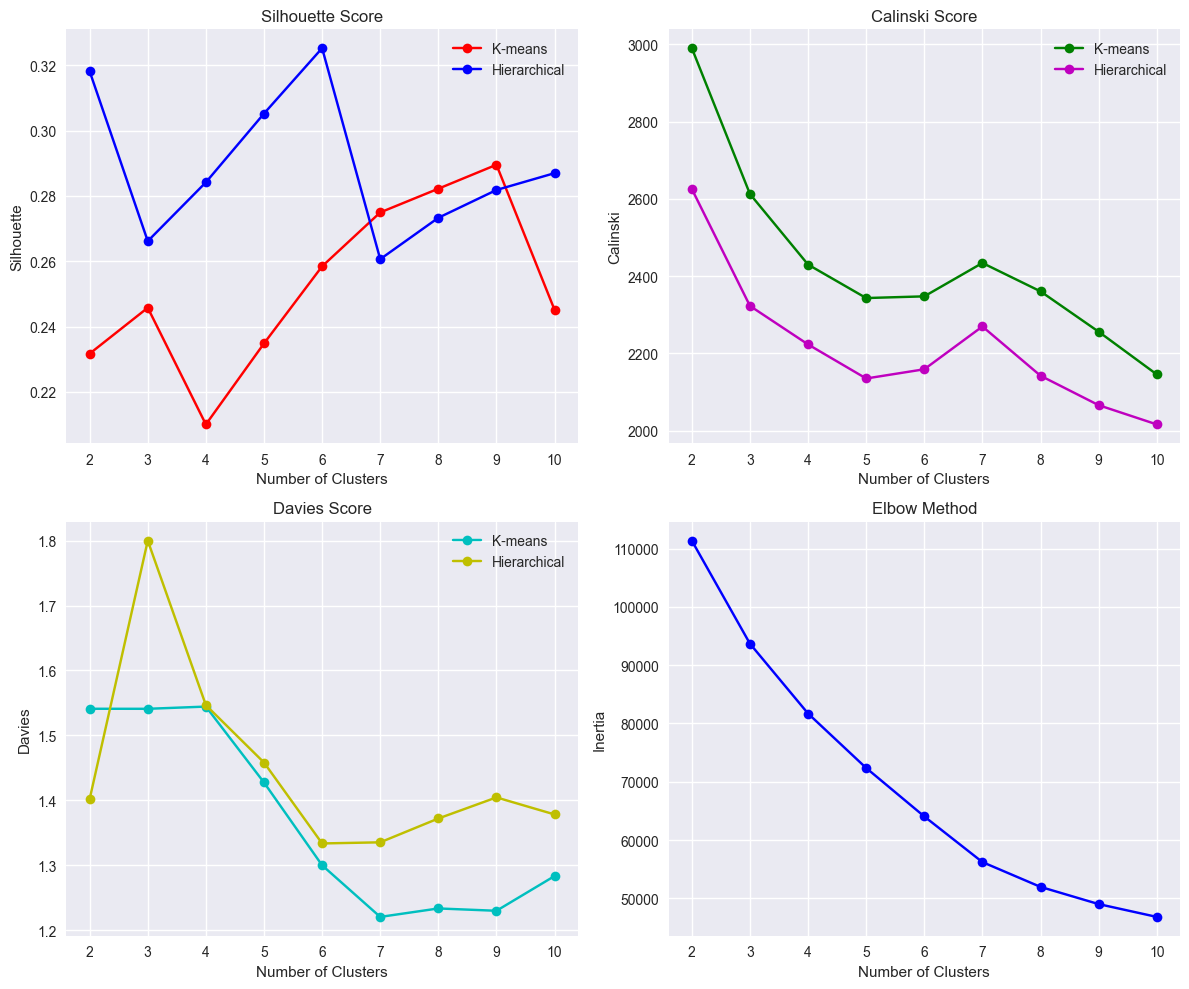

In [28]:
from sklearn.cluster import KMeans, AgglomerativeClustering
def evaluate_clusters(X, max_k=10):
    """Compact clustering evaluation with visualization"""
    K = range(2, max_k + 1)
    methods = {
        'kmeans': lambda k: KMeans(n_clusters=k, random_state=42, n_init=10).fit(X),
        'hierarchical': lambda k: AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    }
    
    # Calculate all metrics
    results = {
        m: {
            'silhouette': [silhouette_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'calinski': [calinski_harabasz_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'davies': [davies_bouldin_score(X, methods[m](k).labels_ if m == 'kmeans' else methods[m](k)) for k in K],
            'inertia': [methods[m](k).inertia_ for k in K] if m == 'kmeans' else None
        } for m in methods
    }

    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['silhouette', 'calinski', 'davies']
    styles = [('ro-', 'bo-'), ('go-', 'mo-'), ('co-', 'yo-')]
    
    for i, (metric, (k_style, h_style)) in enumerate(zip(metrics, styles)):
        ax = axes[i//2, i%2]
        ax.plot(K, results['kmeans'][metric], k_style, label='K-means')
        ax.plot(K, results['hierarchical'][metric], h_style, label='Hierarchical')
        ax.set(xlabel='Number of Clusters', ylabel=metric.capitalize(), title=f'{metric.capitalize()} Score')
        ax.legend()
    
    axes[1,1].plot(K, results['kmeans']['inertia'], 'bo-', label='K-means Inertia')
    axes[1,1].set(xlabel='Number of Clusters', ylabel='Inertia', title='Elbow Method')
    plt.tight_layout()
    
    # Print best results
    for m in methods:
        best_k = K[np.argmax(results[m]['silhouette'])]
        print(f"Best {m} clusters (Silhouette): {best_k} (score: {max(results[m]['silhouette']):.3f})")

# Usage
evaluate_clusters(X_scaled)

Hierarchical clustering with k=6 is clearly optimal:
- Elbow method: After 6, the line starts to flatten
- Silhouette: Hierarchical peaks at k=6 (0.325) vs K-means at k=10 (0.297)
- Davies-Bouldin: Both methods minimize around k=6-7, with hierarchical slightly better
- Calinski-Harabasz: Less decisive but shows hierarchical performing well at k=6

In [29]:
### Perform K-means clustering
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

### Risk Segment Profiling

In [30]:
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [33]:
def calculate_composite_risk(cluster_data, population_bounds):
    """
    Calculate normalized risk score using domain-aligned features
    population_bounds: Precomputed min/max values from entire dataset
    """
    # Feature means for cluster
    util = cluster_data['DEBT_TO_LIMIT_RATIO'].mean()
    cash_risk = cluster_data['CASH_ADVANCE_DEPENDENCY'].mean()
    min_pay = cluster_data['MIN_PAYMENT_RATIO'].mean()
    revolving = cluster_data['REVOLVING_BEHAVIOR'].mean()
    
    # Domain-based normalization (0-1 range)
    def normalize(feature, value):
        low, high = population_bounds[feature]
        return max(0, min(1, (value - low) / (high - low + 1e-8)))
    
    # Normalize with population bounds
    n_util = normalize('DEBT_TO_LIMIT_RATIO', util)  # Higher = worse
    n_cash = normalize('CASH_ADVANCE_DEPENDENCY', cash_risk)  # Higher = worse
    n_minpay = normalize('MIN_PAYMENT_RATIO', min_pay)  # Higher = worse
    n_revolving = normalize('REVOLVING_BEHAVIOR', revolving)  # Binary risk
    
    # Weighted risk formula (domain-aligned weights)
    return (
        0.4 * n_util +
        0.3 * n_cash +
        0.2 * n_minpay +
        0.1 * n_revolving
    )

# Precompute population bounds (do this once for entire dataset)
population_bounds = {
    'DEBT_TO_LIMIT_RATIO': (0, df_risk['DEBT_TO_LIMIT_RATIO'].quantile(0.95)),
    'CASH_ADVANCE_DEPENDENCY': (0, df_risk['CASH_ADVANCE_DEPENDENCY'].quantile(0.95)),
    'MIN_PAYMENT_RATIO': (0, 1),  # Already 0-1 range
    'REVOLVING_BEHAVIOR': (0, 1)   # Binary feature
}

def get_risk_level(score):
    """Classify risk using absolute thresholds"""
    if score >= 0.7:
        return 'CRITICAL'
    elif score >= 0.5:
        return 'HIGH'
    elif score >= 0.3:
        return 'MEDIUM'
    else:
        return 'LOW'

In [34]:
## Profile each risk segment with detailed visualizations

df_risk['RISK_CLUSTER'] = cluster_labels
# Calculate composite risk for each row individually
df_risk['COMPOSITE_RISK'] = df_risk.apply(
    lambda row: calculate_composite_risk(row.to_frame().T, population_bounds), axis=1
)

# Get all scores first, then apply risk levels
all_scores = df_risk['COMPOSITE_RISK'].values
df_risk['RISK_LEVEL'] = df_risk['COMPOSITE_RISK'].apply(
    lambda x: get_risk_level(x, all_scores)
)

# Calculate cluster profiles
cluster_profiles = df_risk.groupby('RISK_CLUSTER')[risk_features].mean()

# Display cluster characteristics
print("=== RISK SEGMENT PROFILES ===\n")
for cluster in sorted(df_risk['RISK_CLUSTER'].unique()):
    cluster_data = df_risk[df_risk['RISK_CLUSTER'] == cluster]

    # Risk categorization based on key risk indicators
    debt_ratio = cluster_data['DEBT_TO_LIMIT_RATIO'].mean()
    cash_dep = cluster_data['CASH_ADVANCE_DEPENDENCY'].mean()
    payment_ratio = cluster_data['PAYMENT_TO_BALANCE_RATIO'].mean()
    
    # Composite risk score
    composite_risk = calculate_composite_risk(cluster_data, population_bounds)
    risk_level = get_risk_level(composite_risk, df_risk['COMPOSITE_RISK'])
    # composite_risk = (debt_ratio * 0.4 + cash_dep * 0.3 + (1 - payment_ratio) * 0.3)
    # risk_level = 'HIGH' if composite_risk > 0.6 else 'MEDIUM' if composite_risk > 0.3 else 'LOW'

    print(f"CLUSTER {cluster} - {risk_level} RISK (n={len(cluster_data)}):")
    print(f"  Composite Risk Score: {composite_risk:.3f}")
    print(f"  Debt-to-Limit Ratio: {debt_ratio:.3f}")
    print(f"  Cash Advance Dependency: {cash_dep:.3f}")
    print(f"  Payment-to-Balance Ratio: {payment_ratio:.3f}")
    print(f"  Minimum Payment Dependency: {cluster_data['MINIMUM_PAYMENT_DEPENDENCY'].mean():.3f}")
    print(f"  Total Activity Level: {cluster_data['TOTAL_ACTIVITY'].mean():.3f}")
    print(f"  Cash Advance Intensity: {cluster_data['CASH_ADVANCE_INTENSITY'].mean():.3f}")
    print(f"  Transaction Frequency: {cluster_data['TRANSACTION_FREQUENCY'].mean():.1f}")
    print(f"  Full Payment Rate: {cluster_data['PRC_FULL_PAYMENT'].mean():.3f}")
    print(f"  Average Tenure: {cluster_data['TENURE'].mean():.1f} months")
    print(f"  Average Balance: ${cluster_data['BALANCE'].mean():,.0f}")
    print(f"  Average Credit Limit: ${cluster_data['CREDIT_LIMIT'].mean():,.0f}")
    print()

KeyError: 'MIN_PAYMENT_RATIO'

In [ ]:
visualizer = ClusterVisualizer(df_risk, cluster_labels, risk_features)

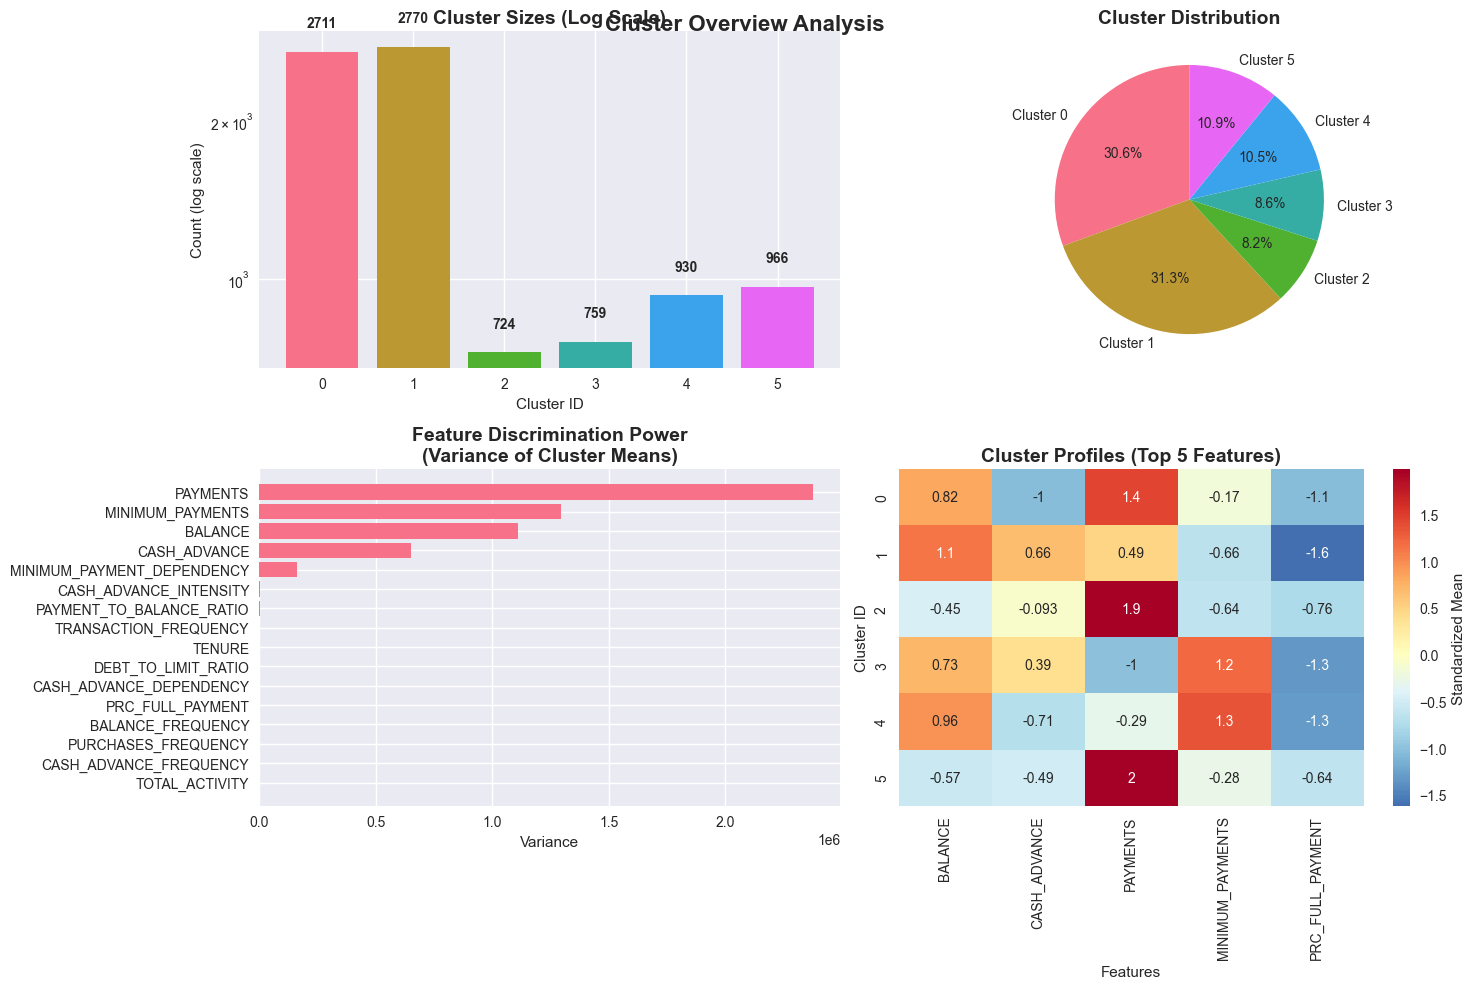

In [ ]:
# Create all visualizations
fig1 = visualizer.plot_cluster_overview()
fig1.suptitle('Cluster Overview Analysis', fontsize=16, fontweight='bold')
plt.show()

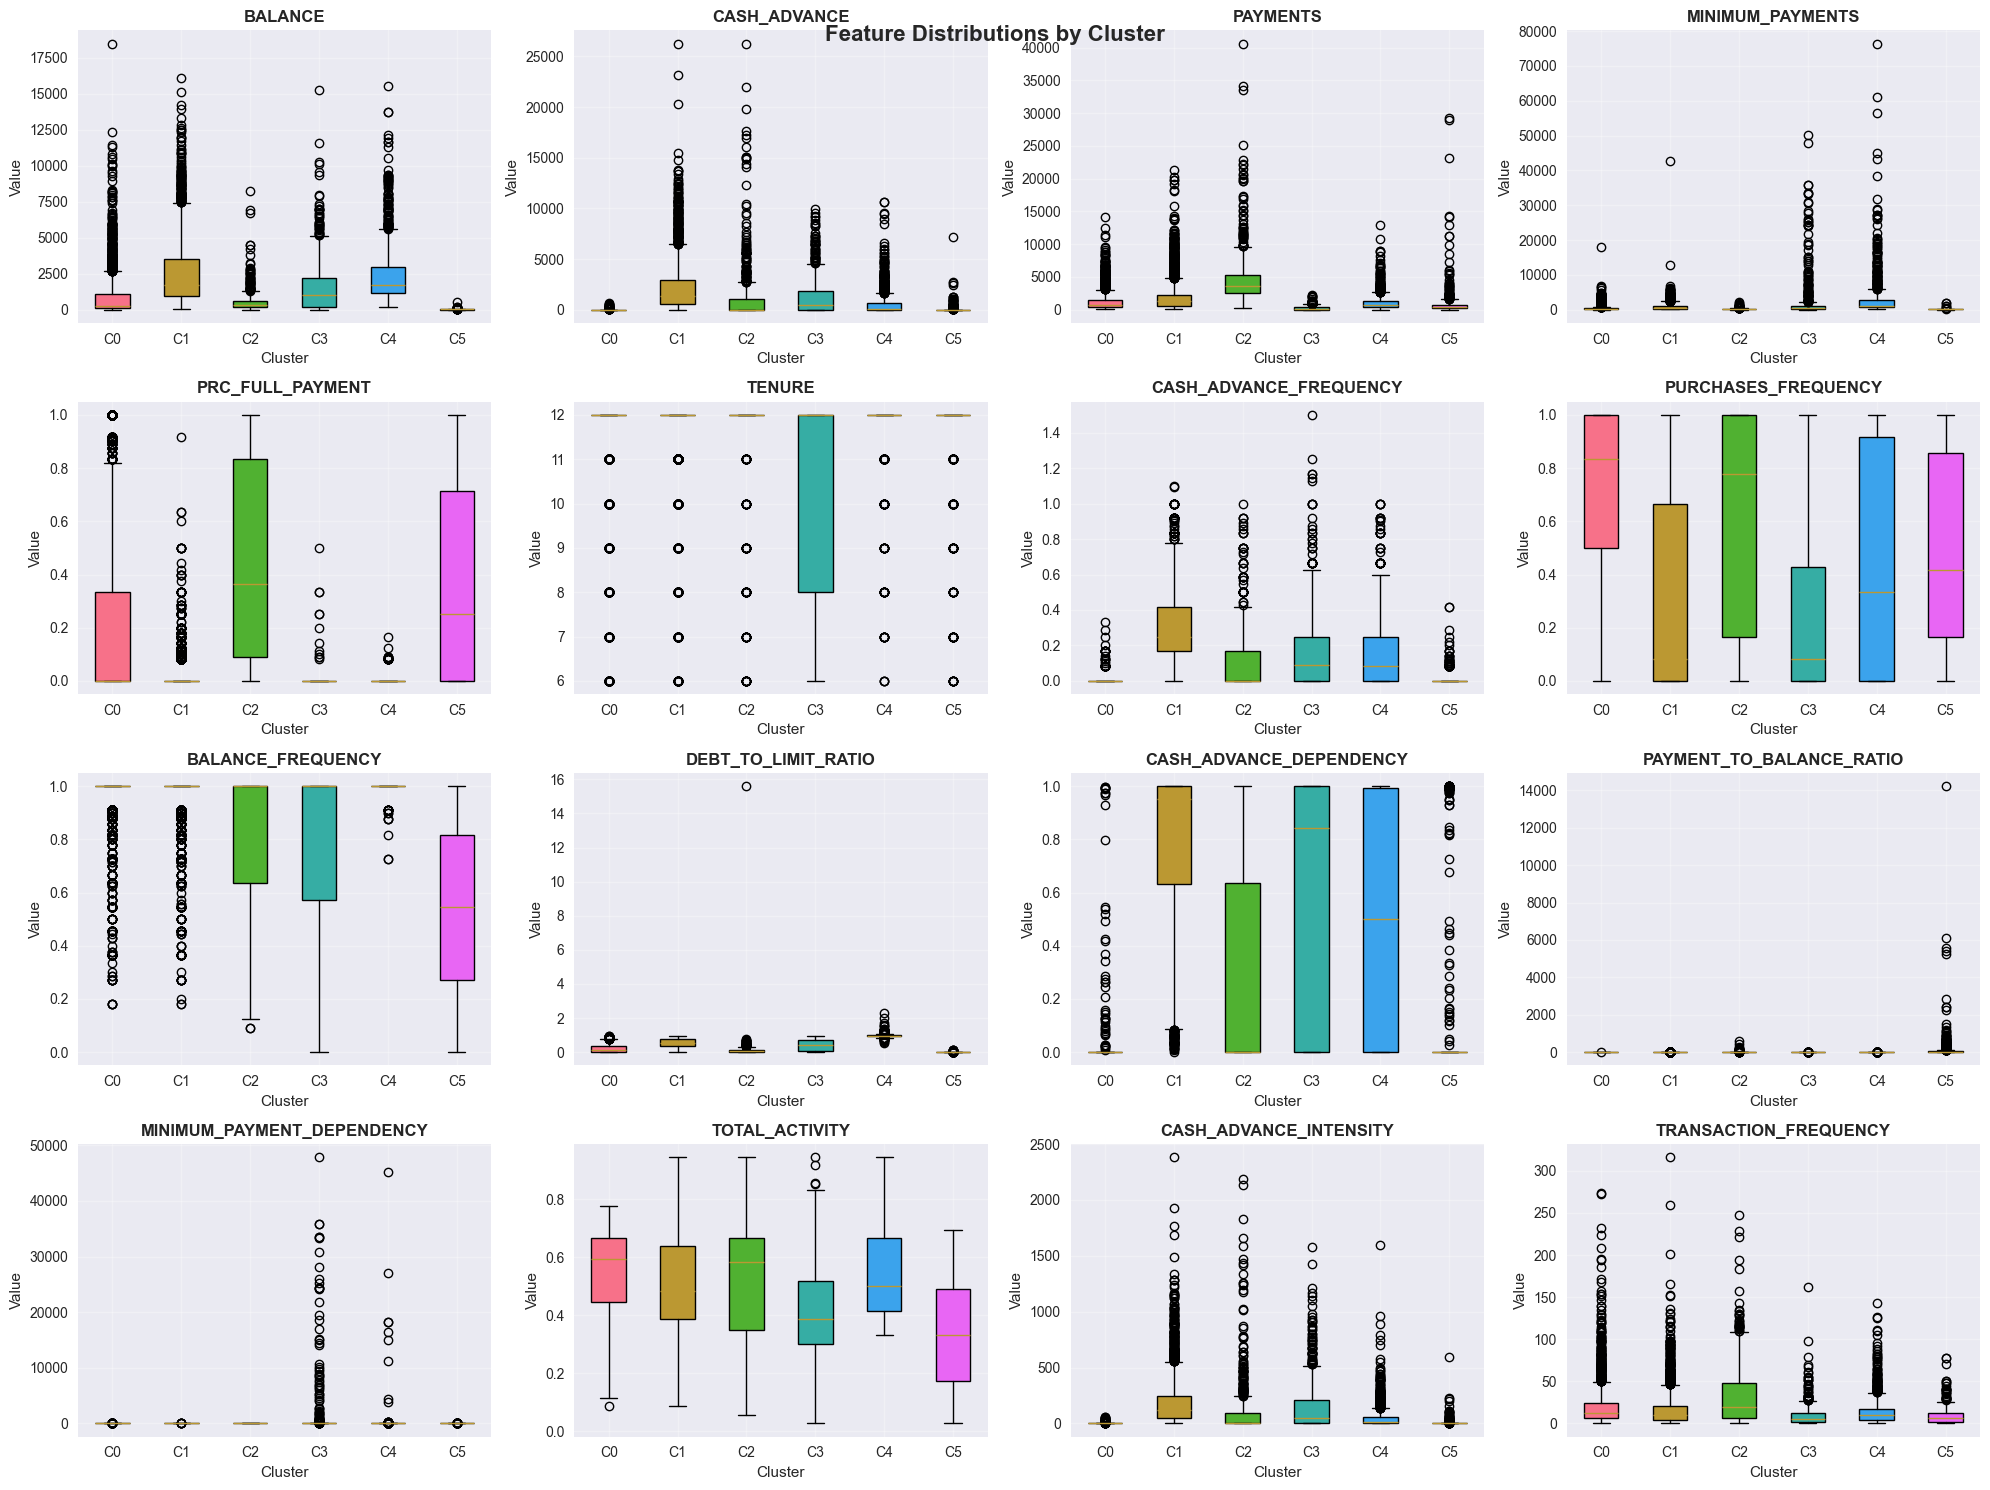

In [ ]:
fig2 = visualizer.plot_feature_distributions()
fig2.suptitle('Feature Distributions by Cluster', fontsize=16, fontweight='bold')
plt.show()

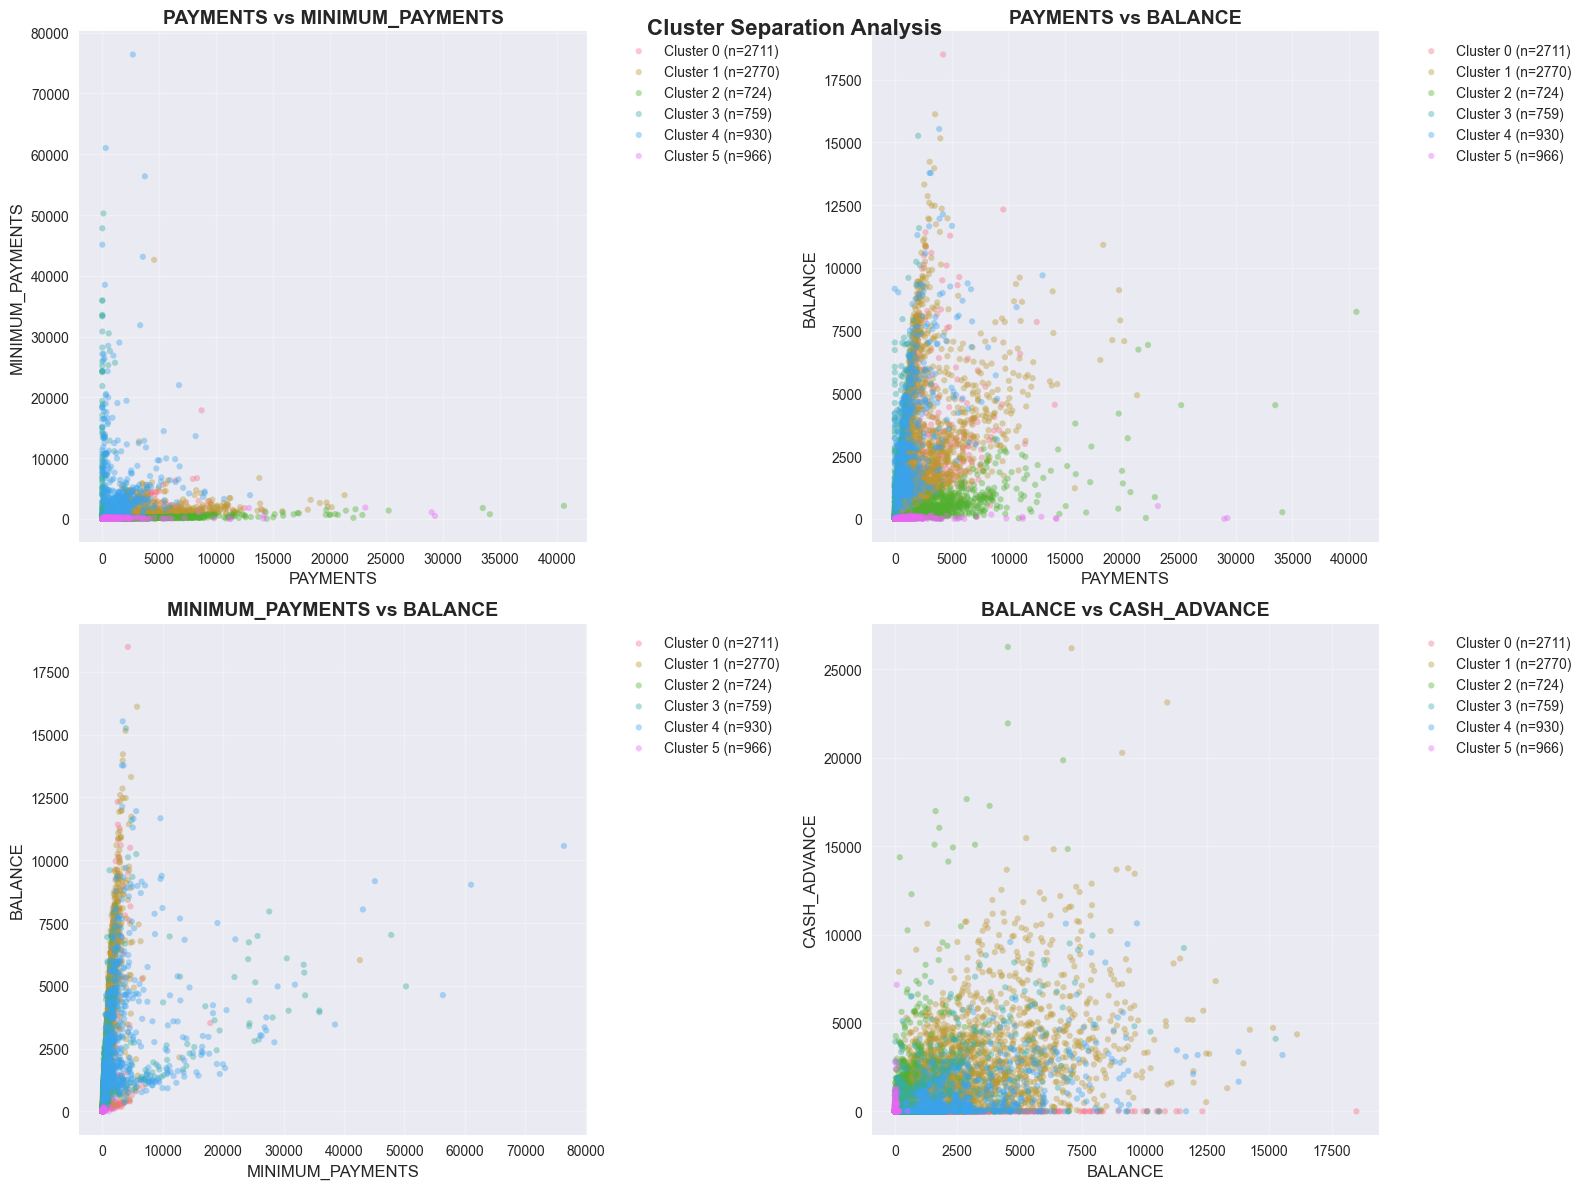

In [ ]:
fig3 = visualizer.plot_cluster_separation()
fig3.suptitle('Cluster Separation Analysis', fontsize=16, fontweight='bold')
plt.show()

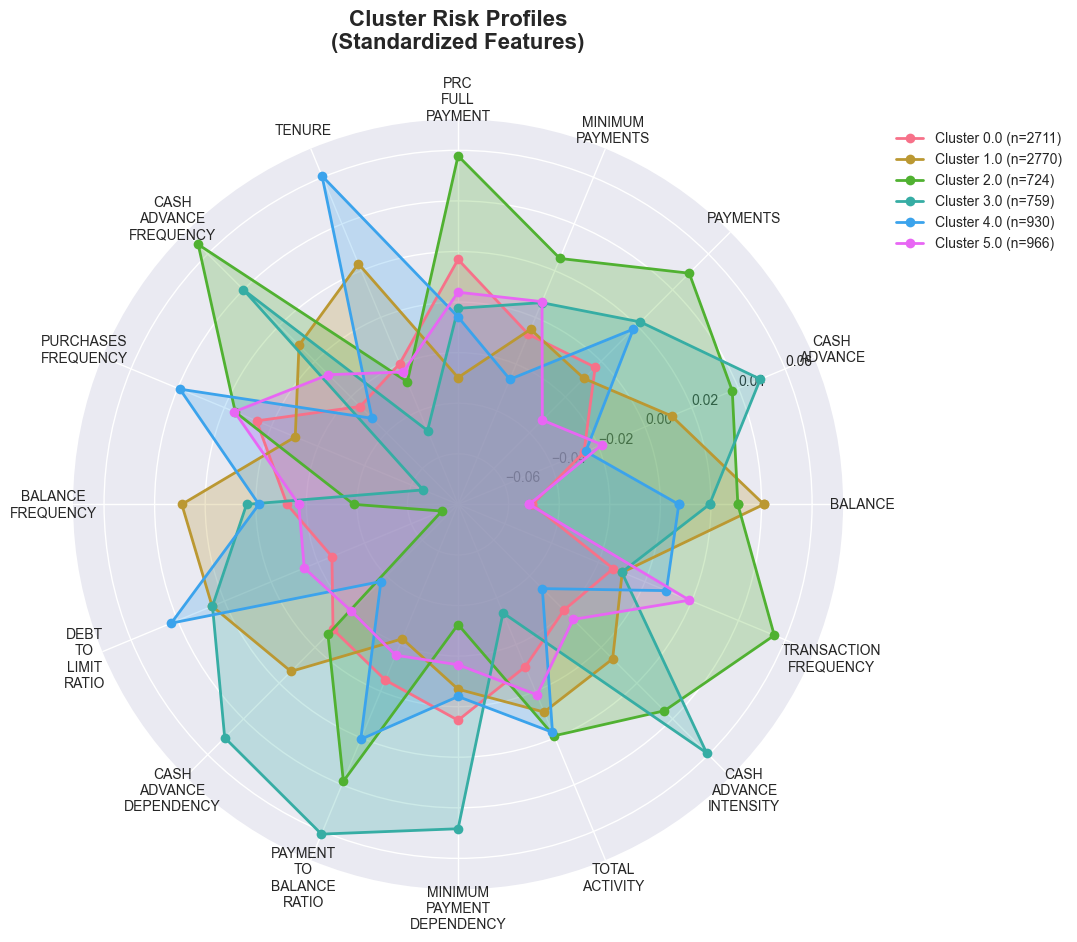

In [ ]:
fig4 = visualizer.plot_cluster_profiles_radar()
plt.show()

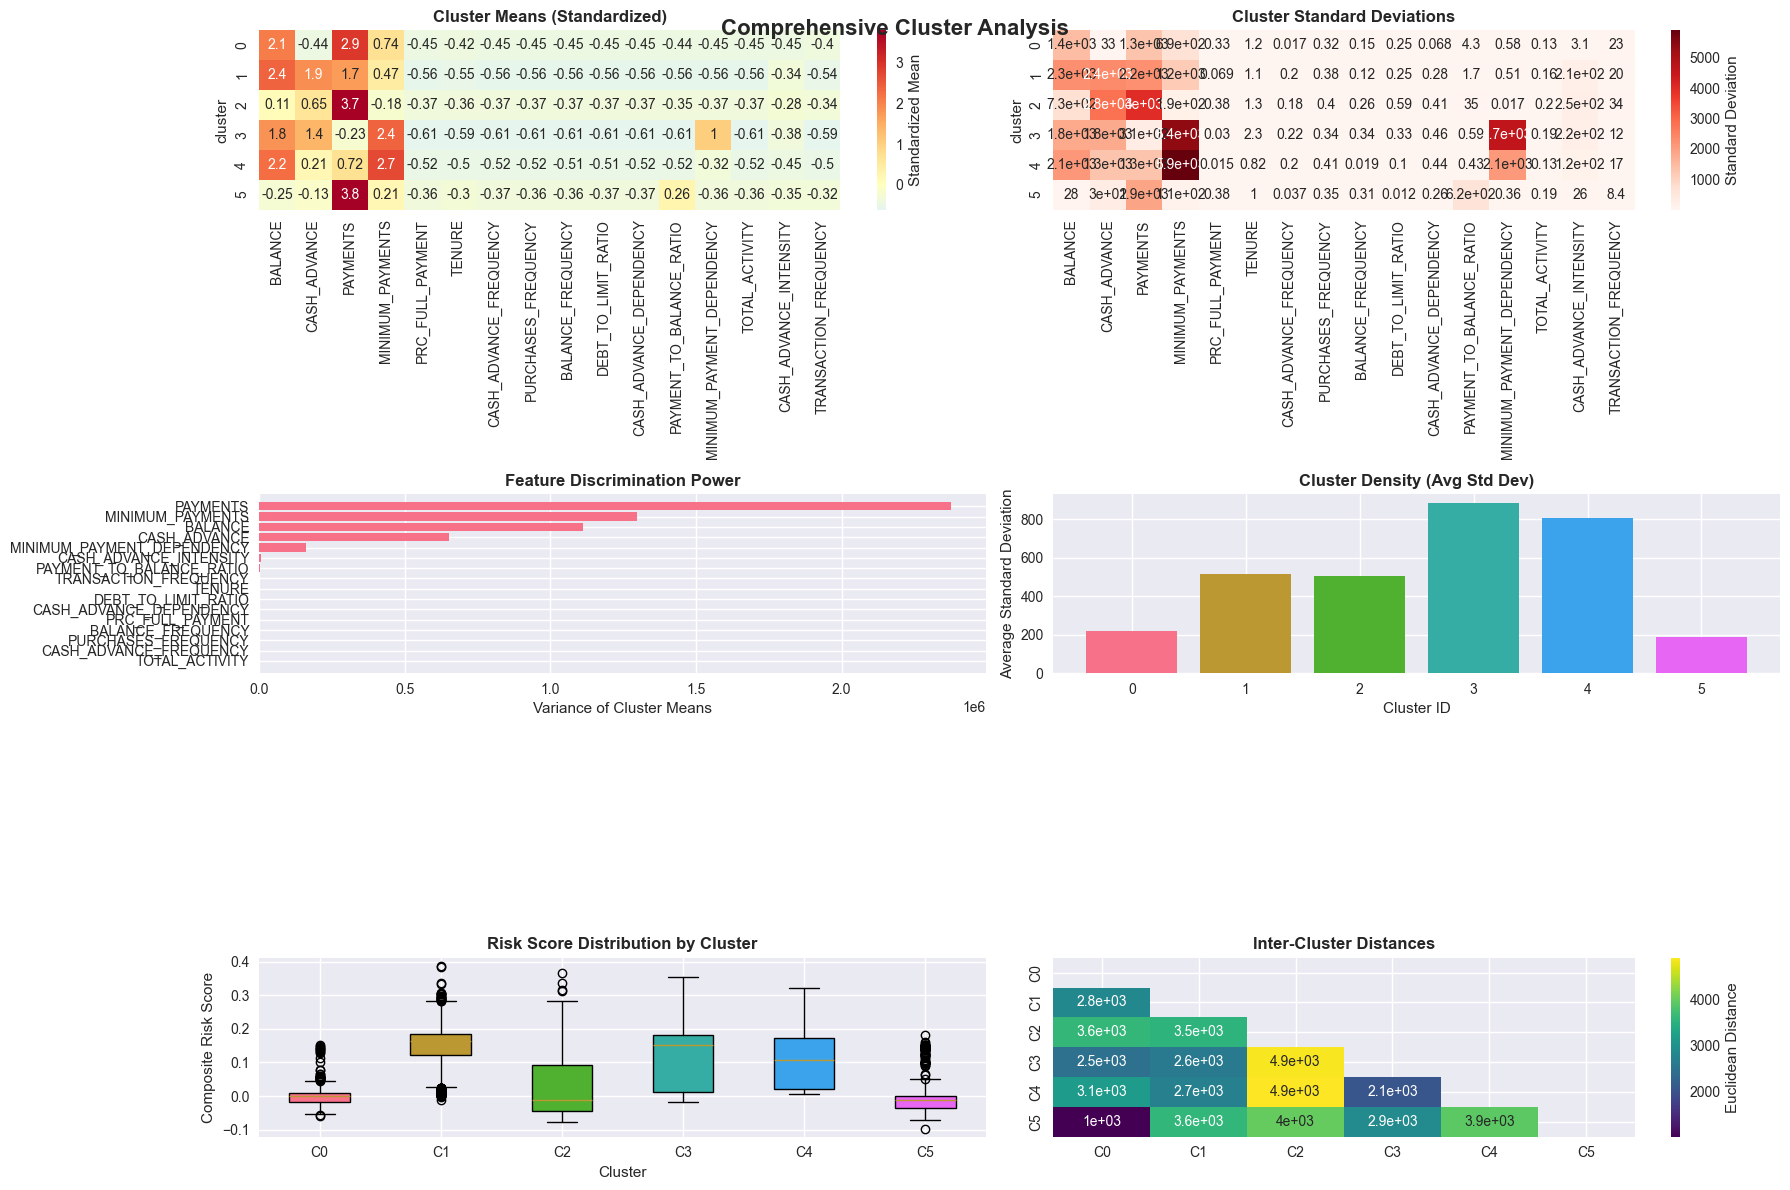

In [ ]:
fig5 = visualizer.plot_summary_statistics()
fig5.suptitle('Comprehensive Cluster Analysis', fontsize=16, fontweight='bold')
plt.show()

### Business Implementation

In [ ]:
# ### Create segment-specific business rules
# rules = {}

# for risk_level in df_risk['RISK_LEVEL'].unique():
#     segment_data = df_risk[df_risk['RISK_LEVEL'] == risk_level]
    
#     rules[risk_level] = {
#         'credit_limit_multiplier': 1.2 if risk_level == 'LOW_RISK' else 
#                                 1.0 if risk_level == 'MEDIUM_RISK' else 0.8,
#         'interest_rate_adjustment': -0.02 if risk_level == 'LOW_RISK' else 
#                                 0.0 if risk_level == 'MEDIUM_RISK' else 0.03,
#         'cash_advance_limit': 0.8 if risk_level == 'LOW_RISK' else 
#                             0.5 if risk_level == 'MEDIUM_RISK' else 0.3,
#         'monitoring_frequency': 'Quarterly' if risk_level == 'LOW_RISK' else 
#                             'Monthly' if risk_level == 'MEDIUM_RISK' else 'Weekly'
#     }

# print("=== BUSINESS IMPLEMENTATION RULES ===\n")
# for risk_level, rule in rules.items():
#     print(f"{risk_level}:")
#     print(f"  Credit Limit Multiplier: {rule['credit_limit_multiplier']}")
#     print(f"  Interest Rate Adjustment: {rule['interest_rate_adjustment']:+.2%}")
#     print(f"  Cash Advance Limit: {rule['cash_advance_limit']:.0%} of credit limit")
#     print(f"  Monitoring Frequency: {rule['monitoring_frequency']}")
#     print()

### A/B testing

In [ ]:
# Split each risk segment for testing
test_groups = {}

for risk_level in df_risk['RISK_LEVEL'].unique():
    segment_data = df_risk[df_risk['RISK_LEVEL'] == risk_level].copy()
    
    # Random split
    np.random.seed(42)
    segment_data['TEST_GROUP'] = np.random.choice(['Control', 'Treatment'], size=len(segment_data))
    
    test_groups[risk_level] = {
        'control_size': len(segment_data[segment_data['TEST_GROUP'] == 'Control']),
        'treatment_size': len(segment_data[segment_data['TEST_GROUP'] == 'Treatment'])
    }

print("=== A/B TESTING FRAMEWORK ===\n")
for risk_level, groups in test_groups.items():
    print(f"{risk_level}:")
    print(f"  Control Group: {groups['control_size']} customers")
    print(f"  Treatment Group: {groups['treatment_size']} customers")
    print()

=== A/B TESTING FRAMEWORK ===

LOW:
  Control Group: 2199 customers
  Treatment Group: 2231 customers

MEDIUM:
  Control Group: 1131 customers
  Treatment Group: 1084 customers

HIGH:
  Control Group: 1131 customers
  Treatment Group: 1084 customers

